In [345]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans Mono'

import os
import wfdb
from scipy.interpolate import interp1d
from sklearn.impute import SimpleImputer

n_indivs = 64
default_freq = 300

# signal from wfdb, human crafted features
signals_pre = np.empty((n_indivs, 90000, 2))
labels = []
ts_files = []
input_path = f'E:/database/gait-in-neurodegenerative-disease-database-1.0.0'
for file_name in sorted(os.listdir(f'{input_path}')):
    if not file_name.endswith('hea'):
        continue
    label = ''.join(filter(lambda x: x.isalpha(), file_name[:-4]))
    file_name = f'{input_path}/{file_name[:-4]}'
    sig, info = wfdb.rdsamp(file_name)

    t = np.arange(len(sig))
    for j in range(2):
        mask_na = np.isnan(sig[..., j])
        f = interp1d(t[~mask_na], sig[~mask_na, j], fill_value='extrapolate')
        sig[mask_na, j] = f(t[mask_na])
    signals_pre[len(labels)] = sig; labels.append( label )
    assert info['fs'] == default_freq
    assert info['sig_len'] == 90000

    ts_file = pd.read_csv(
        file_name + '.ts',
        delimiter='\t',
        names=[
            'Elapsed Time (sec)',
            'Left Stride Interval (sec)', 'Right Stride Interval (sec)', 'Left Swing Interval (sec)', 'Right Swing Interval (sec)',
            'Left Swing Interval (% of stride)', 'Right Swing Interval (% of stride)', 
            'Left Stance Interval (sec)', 'Right Stance Interval (sec)', 
            'Left Stance Interval (% of stride)', 'Right Stance Interval (% of stride)',
            'Double Support Interval (sec)', 'Double Support Interval (% of stride)'
        ]
    )
    ts_files.append(ts_file)

labels = np.array(labels)

# basic clinical data
df_tabular = pd.read_csv(
    f'{input_path}/subject-description.txt', 
    delimiter='\t',
    na_values='MISSING'
)
df_tabular['gender'] = (df_tabular['gender'] == 'm').astype(int)
tabular_data_preimpute = df_tabular.iloc[:, 2:].values

tabular_data = SimpleImputer().fit_transform(features_tabular_preimpute)

In [287]:
from scipy.signal import butter, sosfilt

# signal filtering and scaling
signals = sosfilt(butter(2, 15, btype='low', output='sos', fs=default_freq), signals_pre, axis=-2)
signal_means, signal_stds = np.mean(signals, axis=-2), np.std(signals, axis=-2)
signals = (signals - signal_means[..., np.newaxis, :]) / (signal_stds[..., np.newaxis, :])

In [422]:
seg_len = 450
n_segs_per_indiv = len(list(range(0, signals.shape[1]-signals.shape[1]%seg_len, seg_len)))

# signal partitioning
segs = []
seg_labels = []
seg_indivs = []
mask_nonstart = []
for i in range(signals.shape[0]):
    signal = signals[i]
    for j in range(0, signals.shape[1]-signals.shape[1]%seg_len, seg_len):
        segs.append(signal[j:j+seg_len])
        seg_labels.append( labels[i] )
        seg_indivs.append(i)
        mask_nonstart.append(j >= default_freq*20) # 20s in the beginning discarded
segs = np.array(segs); seg_labels = np.array(seg_labels); seg_indivs = np.array(seg_indivs)
mask_nonstart = np.array(mask_nonstart)

# ts file partitioning
features_ts = np.zeros((n_indivs, n_segs_per_indiv, ts_files[0].shape[1]-1))
mask_turnback = np.full((n_indivs, n_segs_per_indiv), False)
for i in range(n_indivs):
    ts_file = ts_files[i]
    stride_l = ts_file['Left Stride Interval (sec)']; slm = stride_l.median(); sls = stride_l.std()
    stride_r = ts_file['Right Stride Interval (sec)']; srm = stride_r.median(); srs = stride_r.std()
    for _, row in ts_file.iterrows():
        t = row['Elapsed Time (sec)']; dt = row['Left Stride Interval (sec)']
        begin = (t-dt)*default_freq / seg_len
        end = t*default_freq / seg_len
        js = np.arange(int(begin), int(end)+1)
        ratio = np.minimum(js+1, end) - np.maximum(js, begin)
        features_ts[i, js] += ratio[..., np.newaxis]*row.iloc[1:].values
        # for j in range(int(begin), int(end)+1):
        #     ratio = min((j+1), end) - max(j, begin)
        #     features_ts[i*n_segs_per_indiv + j] += ratio*row.iloc[1:]

    # expand left bdry value
    begin = (ts_file.iloc[0, 0]-ts_file.iloc[0, 1])*default_freq / seg_len
    ratio = np.minimum(np.arange(begin, 0, -1), 1)
    features_ts[i, :len(ratio)] += ratio[..., np.newaxis]*ts_file.iloc[0, 1:].values

    # expand right bdry value
    end = ts_file.iloc[-1, 0]* default_freq / seg_len
    ratio = np.minimum(np.arange(int(end), n_segs_per_indiv)-end+1, 1)
    features_ts[i, -len(ratio):] += ratio[..., np.newaxis]*ts_file.iloc[-1, 1:].values

    mask_turnback[i, (np.abs(features_ts[i, :, 0]-slm)>3*sls)|(np.abs(features_ts[i, :, 1]-srm)>3*srs)] = True

features_ts = features_ts.reshape(-1, features_ts.shape[-1])
mask_turnback = mask_turnback.reshape(-1)

# from scipy.interpolate import interp1d

# features_ts = np.empty((segs.shape[0], 12))
# for i in range(signals.shape[0]):
#     ts_file = ts_files[i]
#     x, y = ts_file['Elapsed Time (sec)']*300, ts_file.iloc[:, 1:].values
#     f = interp1d(
#         x, y,
#         axis=0, bounds_error=False, fill_value=(y[0], y[-1]),
#     )
#     features_ts[seg_indivs==i] = f(np.arange(0, signals.shape[1], seg_len) + 0.5*seg_len)

In [186]:
# import tsfresh

# df_segs = pd.DataFrame({
#     'id': np.repeat(np.arange(segs.shape[0]), segs.shape[1]),
#     'time': np.tile(np.arange(segs.shape[1]), (segs.shape[0], )),
#     'left': segs[..., 0].ravel(),
#     'right': segs[..., 1].ravel(),
# })
# df_tsfresh_features = tsfresh.extract_features(
#     df_segs,
#     tsfresh.feature_extraction.settings.EfficientFCParameters(),
#     column_id='id', column_sort='time'
# )

Feature Extraction: 100%|██████████| 40/40 [06:22<00:00,  9.57s/it]


In [370]:
from tools import Embedder, Weighting, SineFilter, calculate_weighting_vectors
import itertools

embedder = Embedder(lag=24, reduce=0, dim_raw=2, channel_last=True)
x = embedder.transform(segs)
w = calculate_weighting_vectors(10*x)[..., np.newaxis]

In [432]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix

mask_non_outlier = mask_nonstart & (~mask_turnback)

sine_filter = SineFilter(dim=x.shape[-1], n_filters=8, scale=1e1, random_state=42)
sine_0d = sine_filter.apply(x, w)

# seg_max = np.max(segs, axis=-2)
# seg_min = np.min(segs, axis=-2)
# seg_mean = np.mean(segs, axis=-2)

features = np.concatenate([
    sine_0d,
    # sine_alter,
    # sine_unif,
    tabular_data[seg_indivs],
    features_ts,
    # signal_means[seg_indivs],
    # signal_stds[seg_indivs]
    # df_tsfresh_features.values
], axis=-1)

subcls = ['als', 'control']
mask_subcls = np.isin(seg_labels, subcls)

y_true = seg_labels.copy()
y_pred = y_true.copy()

rng = np.random.default_rng(42)
# n_fold = 5
# fold_assignment = rng.integers(0, n_fold, size=y_true.shape)
for test_indiv in np.unique(seg_indivs[np.isin(seg_labels, subcls)]):
    # indivs_test = indivs_shuffled[(len(labels)*fold_no)//n_fold:(len(labels)*(fold_no+1))//n_fold]
    # mask_test = np.isin(seg_indivs, indivs_test)

    mask_train = (seg_indivs != test_indiv) & mask_subcls & mask_non_outlier
    mask_test = (seg_indivs == test_indiv) & mask_subcls & mask_non_outlier
    # mask_test = fold_assignment == fold_no
    # mask_train = ~mask_test

    model = make_pipeline(
        # PCA(
        #     n_components=5,
        #     whiten=True,
        #     random_state=42
        # ),
        # KNeighborsClassifier(
        #     n_neighbors=5,
        # )
        LGBMClassifier(
            random_state=42
        )
    )
    model.fit(features[mask_train], seg_labels[mask_train])
    y_pred[mask_test] = model.predict(features[mask_test])
    print(test_indiv, f'{1e2*accuracy_score(y_true[mask_test], y_pred[mask_test]):.2f}')

print()
print(accuracy_score(y_true[mask_subcls & mask_non_outlier], y_pred[mask_subcls & mask_non_outlier])*1e2)
print(confusion_matrix(y_true[mask_subcls & mask_non_outlier], y_pred[mask_subcls & mask_non_outlier]))

0 100.00
1 89.50
2 100.00
3 100.00
4 100.00
5 0.00
6 99.42
7 100.00
8 100.00
9 100.00
10 0.00
11 100.00
12 100.00
13 68.85
14 100.00
15 0.00
16 100.00
17 100.00
18 100.00
19 100.00
20 100.00
21 100.00
22 100.00
23 100.00
24 100.00
25 100.00
26 100.00
27 100.00
28 100.00

87.7630553390491
[[1853  389]
 [ 239 2651]]


(0.0, 12800.0)

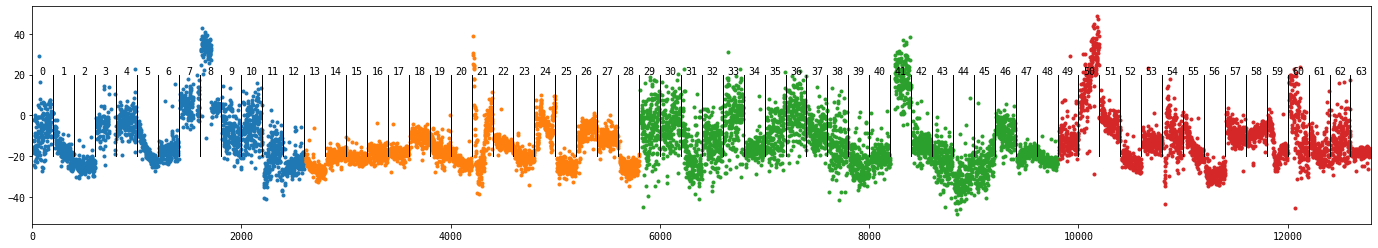

In [470]:
plt.figure(figsize=(24, 4))
for num, label in enumerate(np.unique(labels)):
    mask = (seg_labels == label) & mask_non_outlier
    plt.scatter(np.where(mask)[0], sine_0d[mask, 2], s=9., color=f'C{num}')
for indiv in range(n_indivs):
    plt.vlines(
        x=np.arange(n_indivs)*n_segs_per_indiv, ymin=-20, ymax=20, 
        linewidth=0.5, linestyle='--', color='black')
    plt.text(n_segs_per_indiv*(indiv+0.5), 20, indiv, fontsize=10, ha='center')
plt.xlim(0, x.shape[0])

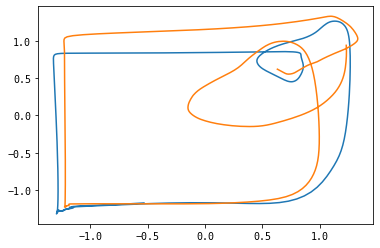

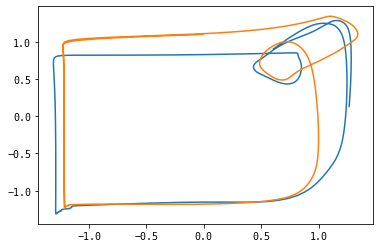

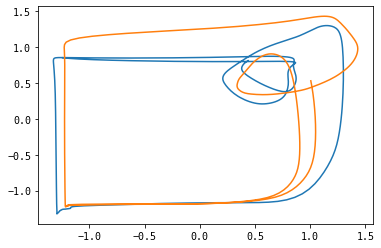

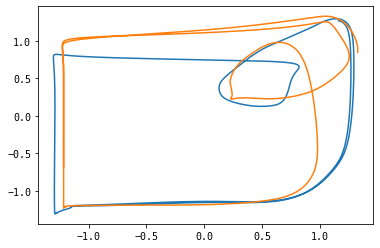

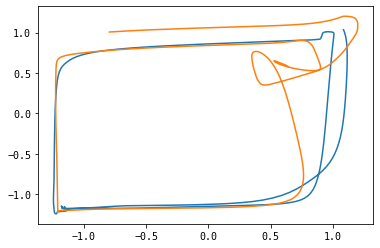

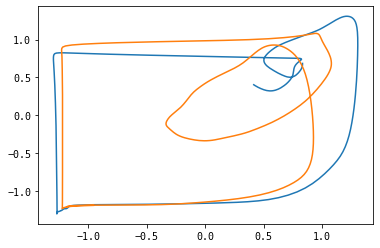

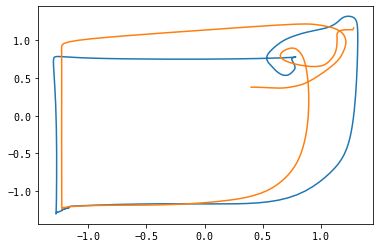

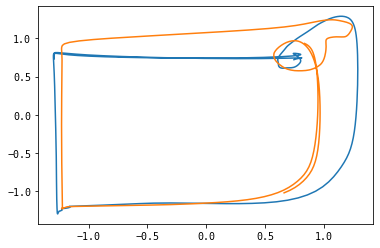

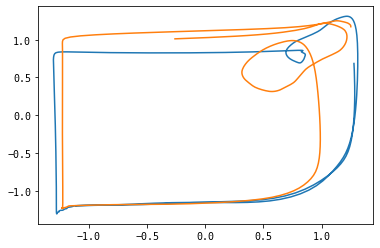

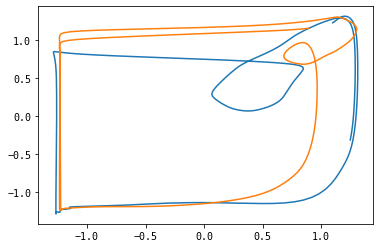

In [482]:
indiv = 12
for index in range(0, 100, 10):
    plt.plot(*x[mask_non_outlier & (seg_indivs==indiv)][index, :, :2].T)
    plt.plot(*x[mask_non_outlier & (seg_indivs==indiv)][index, :, 2:4].T)
    plt.show(); plt.close()

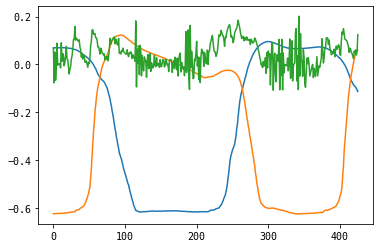

In [115]:
plt.plot( x[mask_nonstart & mask_subcls][1200, :, ::2])
plt.plot( w[mask_nonstart & mask_subcls][1200, :, 0] )

In [ ]:
# plt.plot(x[(y_true==labels[0]) & (y_pred==labels[1])][18])
plt.plot(*x[(y_true==labels[0]) & (y_pred==labels[1])][22, :, :2].T)
plt.plot(*x[(y_true==labels[0]) & (y_pred==labels[1])][22, :, 2:].T)

In [376]:
from umap import UMAP

sine_filter = SineFilter(dim=x.shape[-1], n_filters=32, scale=1e1, random_state=42)
sine_0d = sine_filter.apply(x, w)

w_alter = calculate_weighting_vectors(x)[..., np.newaxis]
sine_alter = sine_filter.apply(x, w_alter)

sine_unif = sine_filter.apply(x, np.ones_like(w))

reducer = UMAP(random_state=42)

reduced_0d = reducer.fit_transform(sine_0d[mask_non_outlier])
reduced_alter = reducer.fit_transform(sine_alter[mask_non_outlier])
reduced_unif = reducer.fit_transform(sine_unif[mask_non_outlier])

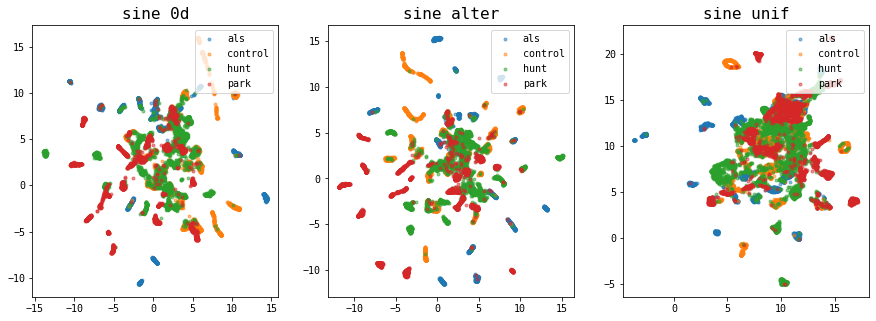

In [391]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
for num, label in enumerate(np.unique(labels)):
    axs[0].scatter(*reduced_0d[seg_labels[mask_non_outlier]==label].T, s=9, color=f'C{num}', alpha=0.5, label=label)
    axs[1].scatter(*reduced_alter[seg_labels[mask_non_outlier]==label].T, s=9, color=f'C{num}', alpha=0.5, label=label)
    axs[2].scatter(*reduced_unif[seg_labels[mask_non_outlier]==label].T, s=9, color=f'C{num}', alpha=0.5, label=label)
ax = axs[0]
ax.set_title('sine 0d', fontsize=16)

ax = axs[1]
ax.set_title('sine alter', fontsize=16)

ax = axs[2]
ax.set_title('sine unif', fontsize=16)

for ax in axs:
    ax.legend(loc='upper right')
plt.show(); plt.close()

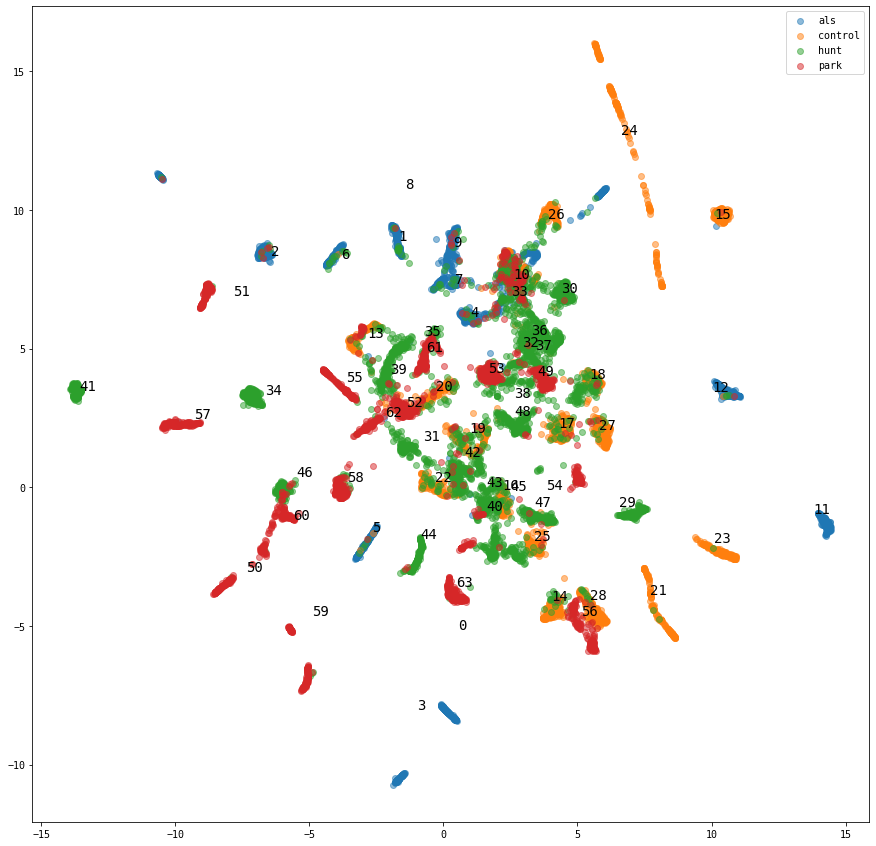

In [403]:
# reduced = reducer.fit_transform(sine_0d[mask_nonstart])
plt.figure(figsize=(15, 15))
for num, label in enumerate(np.unique(labels)):
    plt.scatter(*reduced_0d[seg_labels[mask_non_outlier]==label].T, color=f'C{num}', alpha=0.5, label=label)
for num in range(signals.shape[0]):
    plt.text(*np.mean(reduced_0d[seg_indivs[mask_non_outlier]==num], axis=0), num, fontsize=14)
plt.legend()
plt.show(); plt.close()

In [ ]:
for i in range(signals.shape[0]):
    plt.figure(figsize=(24, 1))
    plt.plot(signals[i, ::3])
    for j in range(100):
        plt.gca().axvline(x=j*300, ymin=0, ymax=1, linestyle='--', linewidth=1, color='#888888')
    for j in range(20):
        plt.gca().axvline(x=j*5*300, ymin=0, ymax=1, linewidth=1, color='#000000')
    for j in range(10):
        plt.gca().axvline(x=j*2*5*300, ymin=0, ymax=1, linewidth=2, color='#000000')
    # plt.title(np.sum(np.isnan(signals[i])))
    plt.title(i)
    plt.xlim(0, 30000)
    plt.show();plt.close()

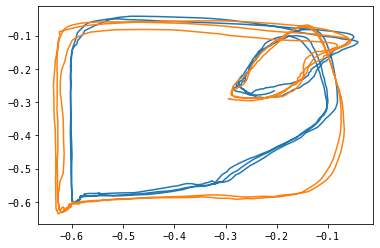

In [31]:
plt.plot(signals[0, 6000:7000], signals[0, 6024:7024])

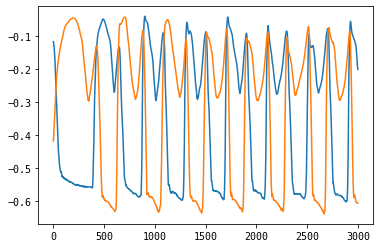

In [11]:
plt.plot(signals[0, 3000:6000])